In [1]:
import os
os.chdir('../')

import pickle as pkl
import pandas as pd
import numpy as np
import seaborn as sns

sns.set(style='darkgrid', palette='muted')

import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

import warnings
warnings.filterwarnings('ignore')

### Load model

In [ ]:
import wandb

run = wandb.init(
    project='leuko-ml',
    name='svc_analysis',
    job_type='download model',
    config={'model': 'svc:v1'} #  sigmoid kernel
)
artifact = run.use_artifact('ernestoserize-constructor-university/leuko-ml/svc:v1', type='model')
artifact_dir = artifact.download()

In [2]:
with open('artifacts/svc:v1/svc.pkl', 'rb') as file:
    svc = pkl.load(file)

### Load data

In [3]:
data = pd.read_csv('artifacts/acute-stroke-selected:v2/new_data.csv')
wandb.config.dataset = 'acute-stroke-selected:v2'

In [4]:
X, y = data.drop('discharge_status', axis=1), data['discharge_status']

### Decision Boundary Analysis

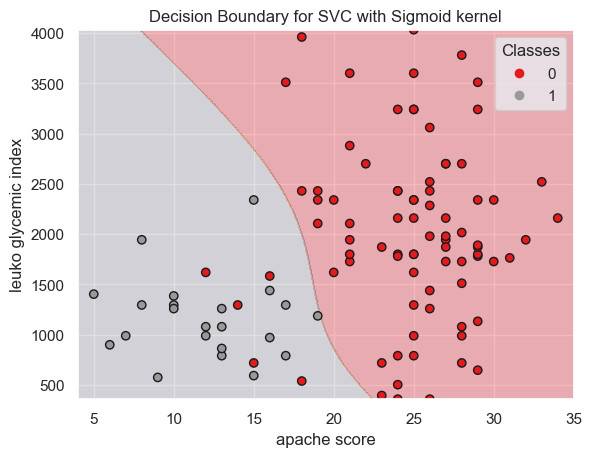

In [ ]:
x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Set1)

scatter = plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=plt.cm.Set1, edgecolor='k')

plt.xlabel('apache score')
plt.ylabel('leuko glycemic index')
plt.title('Decision Boundary for SVC with Sigmoid kernel')
plt.legend(*scatter.legend_elements(), title="Classes")

wandb.log({'decision boundary': wandb.Image(plt)})

plt.show()

### Partial Dependence Plot (PDP)

The plot shows that lower values of both apache and ilg are associated with a higher predicted survive probability. As either apache or ilg increases, the predicted probability of the positive class decreases.

There is a combined nonlinear effect where both high apache and high ilg contribute to a lower survive change. This suggests that both features play a strong role in the model’s predictions, and their effects are interdependent.

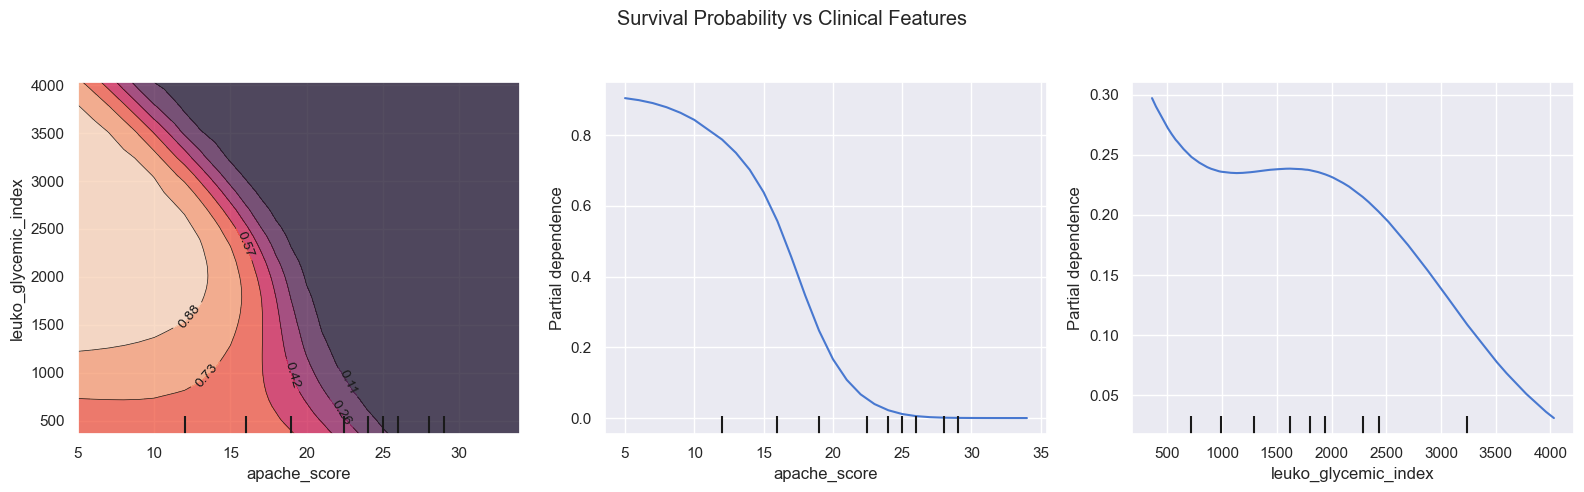

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

features_ = [[(0, 1)],[0],[1]]

for _, i in enumerate(features_):

    PartialDependenceDisplay.from_estimator(
        svc,
        X,
        features=i,
        response_method='predict_proba',
        kind='average',
        grid_resolution=100,
        ax=axes[_]
    )

plt.suptitle('Survival Probability vs Clinical Features')
plt.tight_layout(rect=[0, 0, 1, 0.95])

wandb.log({'survival_probability_pdp': wandb.Image(plt)})

plt.show()

In [ ]:
wandb.finish()